In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import csv
import sklearn
import xgboost as xgb
import keras
import skimage
import random
import matplotlib.pyplot as plt
import cv2
import urllib
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D
from keras import layers
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from skimage import img_as_ubyte
from skimage.transform import rotate, rescale, resize
from PIL import Image

Using TensorFlow backend.


In [ ]:
print(tfds.__version__)

2.1.0


In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
data_train, data_info = tfds.load('rock_paper_scissors', split='train', with_info=True, as_supervised=True)
data_test, data_info = tfds.load('rock_paper_scissors', split='test', with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete1R34Q0/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete1R34Q0/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
data_train, data_test, data_info

(<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>,
 <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>,
 tfds.core.DatasetInfo(
     name='rock_paper_scissors',
     version=3.0.0,
     description='Images of hands playing rock, paper, scissor game.',
     homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
     features=FeaturesDict({
         'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
         'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
     }),
     total_num_examples=2892,
     splits={
         'test': 372,
         'train': 2520,
     },
     supervised_keys=('image', 'label'),
     citation="""@ONLINE {rps,
     author = "Laurence Moroney",
     title = "Rock, Paper, Scissors Dataset",
     month = "feb",
     year = "2019",
     url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
     }""",
     redistribution_info=,
 ))

In [ ]:
def translate(img, shift=10, direction='right', roll=True):
    img = img.copy()
    if shift!=0:  
        if direction=='down':
            diff = img[-shift:]
            img[shift:] = img[:-shift]
            if roll:
                img[:shift] = diff
        elif direction=='up':
            diff = img[:shift]
            img[:-shift] = img[shift:]
            if roll:
                img[-shift:] = diff
        elif direction=='right':
            diff = img[:,-shift:]
            img[:,shift:] = img[:,:-shift]
            if roll:
                img[:,:shift] = diff
        elif direction=='up':
            diff = img[:,:shift]
            img[:,:-shift] = img[:,shift:]
            if roll:
                img[:,-shift:] = diff
    return img

In [ ]:
def random_crop(img, crop_size=(10, 10)):
    assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
    img = img.copy()
    w, h = img.shape[:2]
    x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
    img = img[y:y+crop_size[0], x:x+crop_size[1]]
    return img

In [ ]:
def crop_center(img,cropx,cropy):
    y = img.shape[0]//2
    x = img.shape[1]//2
    return img[y-(cropy//2):y+(cropy//2),x-(cropx//2):x+(cropx//2),:]

In [ ]:
def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img

In [ ]:
def distort(img, orientation='horizontal', func=np.sin, x_scale=0.05, y_scale=5):
    assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
    assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
    assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
    assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
    img_dist = img.copy()
    
    def shift(x):
        return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
        for i in range(img.shape[orientation.startswith('ver')]):
            if orientation.startswith('ver'):
                img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
            else:
                img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
    return img_dist

In [ ]:
x_train = np.zeros((0,150,150,3))
y_train = np.zeros((0))
for img, label in data_train.take(1000):
    img_res = tf.image.resize(img, (150,150)).numpy()
    img4d = np.expand_dims(img_res, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)
    img_rot = rotate(img_res, random.randint(-20,20))
    img4d = np.expand_dims(img_rot, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)

    img_hflip = img_res[:,::-1]
    img4d = np.expand_dims(img_hflip, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)
    img_rot = rotate(img_hflip, random.randint(-20,20))
    img4d = np.expand_dims(img_rot, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)
        
    img_vflip = img_res[:,::-1]
    img4d = np.expand_dims(img_vflip, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)
    img_rot = rotate(img_vflip, random.randint(-20,20))
    img4d = np.expand_dims(img_rot, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)

    img_trans = translate(img_res, random.randint(-20,20), random.choice(['right','left','up','down']))
    img4d = np.expand_dims(img_trans, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)
    img_rot = rotate(img_trans, random.randint(-20,20))
    img4d = np.expand_dims(img_rot, 0)
    x_train = np.append(x_train, img4d, 0)
    y_train = np.append(y_train, label)
    if label==2:
        x_train = np.append(x_train, img4d, 0)
        y_train = np.append(y_train, label)
    print(x_train.shape, y_train.shape)
x_train /= 255
y_train = to_categorical(y_train, 3)
print(x_train.shape, y_train.shape)

(16, 150, 150, 3) (16,)
(32, 150, 150, 3) (32,)
(40, 150, 150, 3) (40,)
(48, 150, 150, 3) (48,)
(56, 150, 150, 3) (56,)
(64, 150, 150, 3) (64,)
(80, 150, 150, 3) (80,)
(88, 150, 150, 3) (88,)
(104, 150, 150, 3) (104,)
(120, 150, 150, 3) (120,)
(128, 150, 150, 3) (128,)
(136, 150, 150, 3) (136,)
(152, 150, 150, 3) (152,)
(160, 150, 150, 3) (160,)
(168, 150, 150, 3) (168,)
(176, 150, 150, 3) (176,)
(184, 150, 150, 3) (184,)
(192, 150, 150, 3) (192,)
(200, 150, 150, 3) (200,)
(208, 150, 150, 3) (208,)
(216, 150, 150, 3) (216,)
(224, 150, 150, 3) (224,)
(232, 150, 150, 3) (232,)
(240, 150, 150, 3) (240,)
(248, 150, 150, 3) (248,)
(256, 150, 150, 3) (256,)
(264, 150, 150, 3) (264,)
(280, 150, 150, 3) (280,)
(296, 150, 150, 3) (296,)
(312, 150, 150, 3) (312,)
(320, 150, 150, 3) (320,)
(328, 150, 150, 3) (328,)
(344, 150, 150, 3) (344,)
(360, 150, 150, 3) (360,)
(376, 150, 150, 3) (376,)
(384, 150, 150, 3) (384,)
(392, 150, 150, 3) (392,)
(408, 150, 150, 3) (408,)
(416, 150, 150, 3) (416,)
(4

In [ ]:
x_test = np.zeros((0,150,150,3))
y_test = np.zeros((0))
for img, label in data_test:
    img_res = tf.image.resize(img, (150,150))
    img4d = np.expand_dims(img_res.numpy(), 0)
    x_test = np.append(x_test, img4d, 0)
    y_test = np.append(y_test, label)
    print(x_test.shape, y_test.shape)
x_test /= 255
y_test = to_categorical(y_test, 3)
print(x_test.shape, y_test.shape)

(1, 150, 150, 3) (1,)
(2, 150, 150, 3) (2,)
(3, 150, 150, 3) (3,)
(4, 150, 150, 3) (4,)
(5, 150, 150, 3) (5,)
(6, 150, 150, 3) (6,)
(7, 150, 150, 3) (7,)
(8, 150, 150, 3) (8,)
(9, 150, 150, 3) (9,)
(10, 150, 150, 3) (10,)
(11, 150, 150, 3) (11,)
(12, 150, 150, 3) (12,)
(13, 150, 150, 3) (13,)
(14, 150, 150, 3) (14,)
(15, 150, 150, 3) (15,)
(16, 150, 150, 3) (16,)
(17, 150, 150, 3) (17,)
(18, 150, 150, 3) (18,)
(19, 150, 150, 3) (19,)
(20, 150, 150, 3) (20,)
(21, 150, 150, 3) (21,)
(22, 150, 150, 3) (22,)
(23, 150, 150, 3) (23,)
(24, 150, 150, 3) (24,)
(25, 150, 150, 3) (25,)
(26, 150, 150, 3) (26,)
(27, 150, 150, 3) (27,)
(28, 150, 150, 3) (28,)
(29, 150, 150, 3) (29,)
(30, 150, 150, 3) (30,)
(31, 150, 150, 3) (31,)
(32, 150, 150, 3) (32,)
(33, 150, 150, 3) (33,)
(34, 150, 150, 3) (34,)
(35, 150, 150, 3) (35,)
(36, 150, 150, 3) (36,)
(37, 150, 150, 3) (37,)
(38, 150, 150, 3) (38,)
(39, 150, 150, 3) (39,)
(40, 150, 150, 3) (40,)
(41, 150, 150, 3) (41,)
(42, 150, 150, 3) (42,)
(43, 150, 

In [ ]:
x_train_shuf, y_train_shuf = shuffle(x_train, y_train)
x_train_shuf.shape, y_train_shuf.shape

((10584, 150, 150, 3), (10584, 3))

In [ ]:
np.savez_compressed('rps_x_train.npz', x_train_shuf)
print("x-train done")
np.savez_compressed('rps_y_train.npz', y_train_shuf)
print("y-train done")
np.savez_compressed('rps_x_test.npz', x_test)
print("x-test done")
np.savez_compressed('rps_y_test.npz', y_test)
print("y-test done")
np.savez_compressed('rps.npz', xtrain=x_train_shuf, ytrain=y_train_shuf, xtest=x_test, ytest=y_test)
print("dataset done")

x-train done
y-train done
x-test done
y-test done
dataset done


In [ ]:
rps_data = np.load('rps.npz')
rps_data

In [ ]:
x_train_shuf = rps_data['xtrain']
print("x-train done")
y_train_shuf = rps_data['ytrain']
print("y-train done")
x_test = rps_data['xtest']
print("x-test done")
y_test = rps_data['ytest']
print("y-test done")

x-train done
y-train done
x-test done
y-test done


In [ ]:
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2), (2,2)))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D((2,2), (2,2)))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D((2,2), (2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
filepath = "best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.fit(x_train_shuf, y_train_shuf, batch_size=32, epochs=5, callbacks=callbacks_list, validation_data=(x_test, y_test), verbose=1)
model.load_weights(filepath)

Train on 10584 samples, validate on 372 samples
Epoch 1/5
10584/10584 [==============================] - 751s 71ms/step - loss: 0.2611 - accuracy: 0.9051 - val_loss: 0.2692 - val_accuracy: 0.9032

Epoch 00001: val_accuracy improved from -inf to 0.90323, saving model to best_weights.hdf5
Epoch 2/5
10584/10584 [==============================] - 746s 70ms/step - loss: 0.0265 - accuracy: 0.9921 - val_loss: 0.0911 - val_accuracy: 0.9704

Epoch 00002: val_accuracy improved from 0.90323 to 0.97043, saving model to best_weights.hdf5
Epoch 3/5
10584/10584 [==============================] - 687s 65ms/step - loss: 0.0107 - accuracy: 0.9957 - val_loss: 0.0284 - val_accuracy: 0.9866

Epoch 00003: val_accuracy improved from 0.97043 to 0.98656, saving model to best_weights.hdf5
Epoch 4/5
10584/10584 [==============================] - 725s 69ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1407 - val_accuracy: 0.9597

Epoch 00004: val_accuracy did not improve from 0.98656
Epoch 5/5
10584/10584 

In [ ]:
img_s1 = Image.open('S1.jpg')
img_s1 = rotate(np.asarray(img_s1),-90)
img_s1.shape

(3456, 3456, 3)

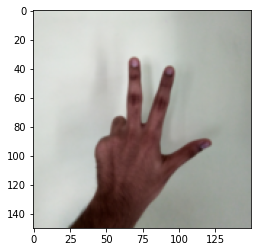

In [ ]:
img_s1 = resize(img_s1, (150,150,3))
plt.imshow(img_s1)
plt.show()

In [ ]:
model.predict(np.expand_dims(img_s1, 0))

array([[1.5096575e-05, 4.5775659e-03, 9.9540734e-01]], dtype=float32)

In [ ]:
img_p1 = Image.open('P1.jpg')
img_p1 = rotate(np.asarray(img_p1), -90)
img_p1.shape

(3456, 3456, 3)

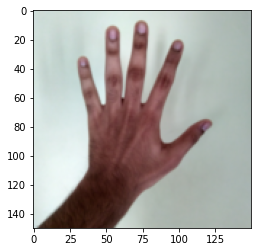

In [ ]:
img_p1 = resize(img_p1, (150,150,3))
plt.imshow(img_p1)
plt.show()

In [ ]:
model.predict(np.expand_dims(img_p1, 0))

array([[3.8249445e-11, 9.8538381e-01, 1.4616136e-02]], dtype=float32)

In [ ]:
img_r1 = Image.open('R1.jpg')
img_r1 = rotate(np.asarray(img_r1),-90)
img_r1.shape

(3456, 3456, 3)

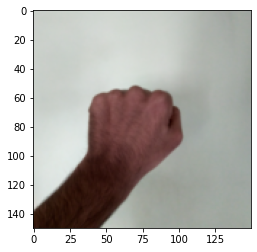

In [ ]:
img_r1 = resize(img_r1, (150,150,3))
plt.imshow(img_r1)
plt.show()

In [ ]:
model.predict(np.expand_dims(img_r1, 0))

array([[9.9940217e-01, 1.7681034e-05, 5.8015448e-04]], dtype=float32)